In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

%matplotlib inline

plt.rcParams['figure.figsize']  = (16, 8)
plt.rcParams['axes.labelsize']  = 10
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['lines.linewidth'] = 8.5

In [2]:
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

### Importando Dados

In [3]:
# Importando dataset
dados = pd.read_excel("./datasets/dados_posGraduacao_UFMG.xlsx")

In [4]:
# Removendo linhas invalidas
nomeProgramas = list(dados["NomePrograma"].astype(str))
dados["NomePrograma"] = ["-" if nomePrograma == 'nan' else nomePrograma for nomePrograma in nomeProgramas]

# Removendo programas que não tiveream modalidade de doutorado avaliada
notasCapesDoutorado = list(dados["NotaCapesDoutorado"].astype(str))
notasCapesDoutorado = ["-" if nota == "0.0" else nota for nota in notasCapesDoutorado]
dados["NotaCapesDoutorado"] = notasCapesDoutorado

# Removendo programas que não tiveream modalidade de mestrado avaliada
notasCapesMestrado = list(dados["NotaCapesMestrado"].astype(str))
notasCapesMestrado = ["-" if nota == "0.0" else nota for nota in notasCapesMestrado]
notasCapesMestrado = ["-" if nota == "nan" else nota for nota in notasCapesMestrado]
dados["NotaCapesMestrado"] = notasCapesMestrado

# Removendo entradas inferiores a 2008 e programas criados apos 
dados2 = dados.query(
    "AnoBase >= 2008"
).query(
    "AnoBase <= 2017"
).query(
    "NotaCapesMestrado != '-'"
).query(
    "NotaCapesDoutorado != '-'"
).query(
    "NomePrograma != '-'"
)

dados08_17 = dados2[['CodigoPrograma','AnoBase',]].groupby(["CodigoPrograma"], as_index=False).count()
dados08_17 = dados08_17.query("AnoBase == 10")
dados08_17 = dados08_17[['CodigoPrograma']]

# Seleciona apenas programas com atividade entre 2008-2018
dados08_17 = pd.merge(dados2,dados08_17, on="CodigoPrograma", how="right") 
dados08_17[['NotaCapesMestrado','NotaCapesDoutorado']] = dados08_17[['NotaCapesMestrado','NotaCapesDoutorado']].astype(float)
dados2.groupby(["CodigoPrograma"]).count()
dados08_17.head(5)

,Unnamed: 0,Chave,AnoBase,BolsasDoutorado,BolsasMestrado,CodigoPrograma,Dissertacao,NomePrograma,NotaCapesDoutorado,NotaCapesMestrado,ProducoesArtisticas,ProducoesBibliograficas,ProducoesTecnicas,NumTeses,ValorAnualBolsaDoutorado,ValorAnualBolsaMestrado
0,19,32001010051P42008,2008.0,2.0,9.0,32001010051p4,19.0,artes,5.0,5.0,126.0,162.0,237.0,1.0,43200.0,129600.0
1,22,32001010051P42009,2009.0,2.0,12.0,32001010051p4,25.0,artes,5.0,5.0,164.0,197.0,235.0,0.0,43200.0,172800.0
2,23,32001010051P42010,2010.0,4.0,21.0,32001010051p4,31.0,artes,5.0,5.0,146.0,125.0,157.0,6.0,86400.0,302400.0
3,28,32001010051P42011,2011.0,14.0,28.0,32001010051p4,37.0,artes,5.0,5.0,148.0,139.0,201.0,16.0,302400.0,403200.0
4,29,32001010051P42012,2012.0,15.0,24.0,32001010051p4,27.0,artes,5.0,5.0,111.0,135.0,256.0,18.0,324000.0,345600.0


### Normalizando os dados

In [6]:
num_columns = [
    "BolsasDoutorado",
    "BolsasMestrado",
    "Dissertacao",
    "ProducoesArtisticas",
    "ProducoesBibliograficas",
    "ProducoesTecnicas",
    "NumTeses",
    "ValorAnualBolsaDoutorado",
    "ValorAnualBolsaMestrado"
]

df_numerical = dados08_17
df_numerical = df_numerical.groupby("NomePrograma", as_index=False).sum()

# Calc score z of columns
mean = df_numerical.mean()
std = df_numerical.std(ddof=1)
df_numerical[num_columns] = (df_numerical[num_columns] - mean[num_columns]) /(std[num_columns])
df_numerical.head(5)

,NomePrograma,Unnamed: 0,AnoBase,BolsasDoutorado,BolsasMestrado,Dissertacao,NotaCapesDoutorado,NotaCapesMestrado,ProducoesArtisticas,ProducoesBibliograficas,ProducoesTecnicas,NumTeses,ValorAnualBolsaDoutorado,ValorAnualBolsaMestrado
0,administração,6006,20125.0,-0.340340,-0.145982,0.291900,52.0,52.0,-0.169386,0.816603,1.867276,0.409653,-0.346725,-0.157440
1,arquitetura,297,10050.0,-1.358121,-0.899134,-0.912521,23.0,23.0,0.003822,-1.127832,-0.234353,-1.288739,-1.390754,-0.970953
2,arquitetura e urbanismo,3408,10075.0,-0.617019,-0.677619,-0.871831,28.0,28.0,0.143722,-0.697663,0.220053,-0.689306,-0.552834,-0.592207
3,artes,3416,20125.0,-0.389747,0.762230,0.357004,53.0,53.0,7.618334,-0.124105,1.099486,0.272283,-0.378508,0.753500
4,bioinformática,5695,20125.0,0.568746,-0.732998,-1.197350,61.0,61.0,-0.149401,0.138014,-0.388433,-0.289685,0.585580,-0.634831


### Analisando PCA

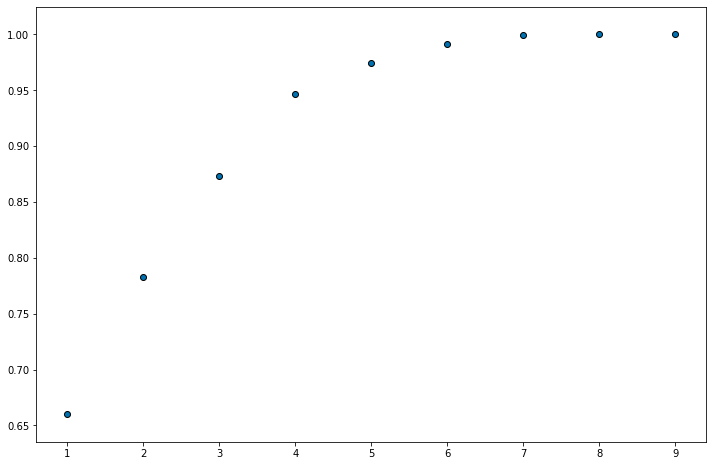

In [7]:
n = df_numerical[num_columns].shape[1]
components = list(range(1,n+1))
y = []
for k in components:
    pca = PCA(n_components=k)
    pca = pca.fit(df_numerical[num_columns])
    y.append(pca.explained_variance_ratio_.sum())
plt.scatter(components, y, edgecolors='k')

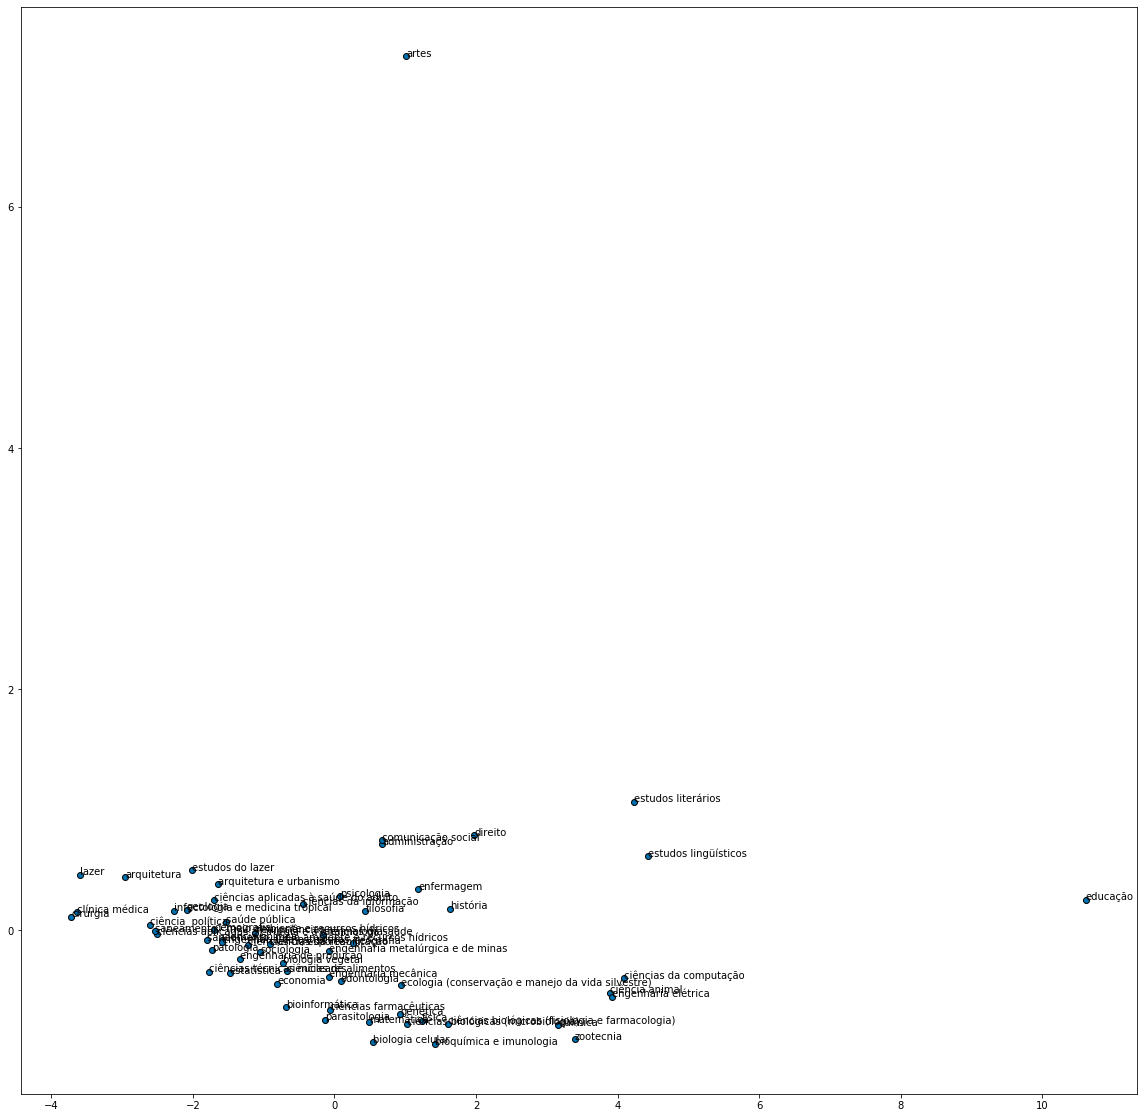

In [8]:
plt.figure(figsize=(20, 20))

pca = PCA(n_components=2)
pca = pca.fit(df_numerical[num_columns])
N = pca.transform(df_numerical[num_columns])
plt.scatter(N[:, 0], N[:, 1],  edgecolors='k')
ax = plt.gca()
for i, txt in enumerate(df_numerical['NomePrograma']):
    ax.annotate('{}'.format(txt), (N[:, 0][i], N[:, 1][i]))

### Classificação

In [9]:
dados = pd.read_excel("./datasets/dados_posGraduacao_UFMG.xlsx")

# Removendo entradas inferiores a 2008 e menores que 2018
dados08_17 = dados.query("AnoBase >= 2008")
dados08_17 = dados08_17.query("AnoBase < 2018")

# Removendo cursos sem nome
dados08_17 =  dados08_17[pd.notnull(dados08_17['NomePrograma'])]
# Consertando tipo dos dados
# Algumas bolsas estao como string ou -
def series_to_num(df):
    # copio o df para n ter problemas com pandas
    df_to_return = df.copy()
    df_to_return = df_to_return.replace('-', np.nan)
    df_to_return = pd.to_numeric(df_to_return)
    return df_to_return

# Tratando para as colunas Bolsas e Notas da Capes:
dados08_17['BolsasDoutorado'] = series_to_num(dados08_17['BolsasDoutorado'])
dados08_17['BolsasMestrado'] = series_to_num(dados08_17['BolsasMestrado'])
dados08_17['NotaCapesDoutorado'] = series_to_num(dados08_17['NotaCapesDoutorado'])
dados08_17['NotaCapesMestrado'] = series_to_num(dados08_17['NotaCapesMestrado'])

# Removendo cursos sem nota capes
dados08_17 = dados08_17[pd.notnull(dados08_17['NotaCapesMestrado'])]
dados08_17 = dados08_17[pd.notnull(dados08_17['NotaCapesDoutorado'])]

# Removendo cursos com modalidades que nao existiam ainda e por isso tem valor da bolsa 0 no dataframe
dados08_17 =dados08_17.query('ValorAnualBolsaMestrado > 0')
dados08_17 = dados08_17.query('ValorAnualBolsaDoutorado > 0')

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV

#### Normalização do DataSet

In [11]:
num_columns = [
    "BolsasDoutorado",
    "BolsasMestrado",
    "Dissertacao",
    "ProducoesArtisticas",
    "ProducoesBibliograficas",
    "ProducoesTecnicas",
    "NumTeses",
    "ValorAnualBolsaDoutorado",
    "ValorAnualBolsaMestrado"
]

df_numerical = dados08_17
##df_numerical = df_numerical.groupby("NomePrograma", as_index=False).sum()

# Calc score z of columns
mean = df_numerical.mean()
std = df_numerical.std(ddof=1)
df_numerical[num_columns] = (df_numerical[num_columns] - mean[num_columns]) /(std[num_columns])
df_numerical
cursos_mestrado = dados08_17[["NumTeses", "NomePrograma", "AnoBase", "BolsasMestrado", "NotaCapesMestrado", "ValorAnualBolsaMestrado", "Dissertacao", "ProducoesBibliograficas", "ProducoesTecnicas", "ProducoesArtisticas", "CodigoPrograma"]]
cursos_doutorado = dados08_17[["NumTeses", "NomePrograma", "AnoBase", "BolsasDoutorado", "NotaCapesDoutorado", "ValorAnualBolsaDoutorado", "Dissertacao", "ProducoesBibliograficas", "ProducoesTecnicas", "ProducoesArtisticas", "CodigoPrograma"]]


#### Classificação dos cursos de mestrado

In [12]:
## Criando o dataset

y = cursos_mestrado["NotaCapesMestrado"]
y = np.array(y)
X = [cursos_mestrado["NumTeses"], cursos_mestrado["BolsasMestrado"], cursos_mestrado["Dissertacao"], cursos_mestrado["ProducoesArtisticas"], cursos_mestrado["ProducoesBibliograficas"], cursos_mestrado["ProducoesTecnicas"]]
X = np.array(X).T

## Separando entre entradas de teste e entradas de treino

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

knn = KNeighborsClassifier()
knn = GridSearchCV(knn, {'n_neighbors':range(1,45)}, cv=5, iid=False)
knn.fit(X_train, y_train) 

knn_train = knn.score(X_train, y_train)
knn_test = knn.score(X_test, y_test)

print('Precision train: %.2f' % knn_train)
print('Precision test: %.2f' % knn_test)

y_pred = knn.predict(X_test)

print("confusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("recall: %.2f" % recall_score(y_test, y_pred, average='macro',))


/home/joesty/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Precision train: 0.61
Precision test: 0.51
confusion matrix:
[[ 0  0  0  1  0]
 [ 0  9  7  1  2]
 [ 0  3 11  2  2]
 [ 0  3  0  4  2]
 [ 0  0  3  2  5]]
recall: 0.41


#### Classificação dos cursos de doutorado

In [13]:
## Criando o dataset

y = cursos_doutorado["NotaCapesDoutorado"]
y = np.array(y)
X = [cursos_doutorado['NumTeses'], cursos_doutorado["BolsasDoutorado"], cursos_doutorado["Dissertacao"], cursos_doutorado["ProducoesArtisticas"], cursos_doutorado["ProducoesBibliograficas"], cursos_doutorado["ProducoesTecnicas"]]
X = np.array(X).T

## Separando entre entradas de teste e treino

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

knn = KNeighborsClassifier()
knn = GridSearchCV(knn, {'n_neighbors':range(1,45)}, cv=5, iid=False)
knn.fit(X_train, y_train) 

knn_train = knn.score(X_train, y_train)
knn_test = knn.score(X_test, y_test)
print('Precision train: %.2f' % knn_train)
print('Precision test: %.2f' % knn_test)

y_pred = knn.predict(X_test)
print("confusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("recall: %.2f" % recall_score(y_test, y_pred, average='macro',))


/home/joesty/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Precision train: 0.70
Precision test: 0.42
confusion matrix:
[[0 0 0 0 1]
 [0 9 7 2 1]
 [0 3 8 7 0]
 [0 1 2 4 2]
 [0 1 2 4 3]]
recall: 0.33
